# Introduction to Multi-Armed Bandits

Multi-Armed Bandits is a classic problem in the field of Reinforcement Learning, where a player is faced with multiple levers or arms and must decide which arm to pull at each step, with the aim of maximizing their total reward over time. The player is faced with the trade-off between exploration and exploitation, as they must balance trying out different arms to learn their reward distribution, while also exploiting their current knowledge to choose the arm with the highest expected reward.

In this Jupyter Notebook, we will explore various algorithms used to solve the Multi-Armed Bandit problem, including Epsilon-Greedy, Upper Confidence Bound (UCB), and Boltzmann exploration. We will implement these algorithms and compare their performance on different test problems. The aim of this notebook is to provide a comprehensive understanding of the Multi-Armed Bandit problem and the various solutions available, along with practical implementation in Python. So, let's dive into the world of Multi-Armed Bandits and discover the best strategy to tackle this classic problem.

In the first step, we create a class in Python that represents a multi-armed bandit. To create the class, the numpy package must first be loaded. 


In [1]:
import numpy as np

We will also create a helper function to check that our class is called correctly. The function checks whether a variable is a positive natural number. Within the class, we want to use it to verify that the playing time of the multi-armed bandit is a positive natural number. 

In [2]:
def is_positive_integer(value):
    if isinstance(value, int) and value > 0:
        return True
    return False

In the next step we will create the complete class, but then we will go over the individual steps again. 

In [3]:
class BernoulliBanditEnv():
    def __init__(self, p_parameter, max_steps):
        """create a multiarm bandit with `len(p_parameter)` arms

        Args:
            p_parameter (list): list containing mean parameter of bandit arms 
            max_steps (int): number of steps for the bandit problem
        """
        # check if valid parameter were used
        assert (np.array(p_parameter) < 1).all(
        ), "Parameter p must be between 0 and 1."
        assert (0 < np.array(p_parameter)).all(
        ), "Parameter p must be between 0 and 1."
        assert is_positive_integer(
            max_steps), f"max_steps has to be a positive integer but is {max_steps}"
        self.p_parameter = p_parameter
        self.n_arms = len(p_parameter)
        self.max_steps = max_steps
        self.count = 0

        # to save regret statistics
        self.optimal = [max(self.p_parameter),
                        self.p_parameter.index(max(self.p_parameter))]
        self.played_optimal = 0
        self.regret = 0.0

    def step(self, action):
        """play a step of the multiarmed bandit, given an action

        Args:
            action (int): chosen arm 

        Returns:
            list: next state, reward, info if done, game info
        """
        # check, if the action is valid
        assert action in range(
            self.n_arms), f"the action {action} is not valid"
        
        # sample the reward, depending on the chosen arm
        if np.random.uniform() < self.p_parameter[action]:
            reward = 1.0
        else:
            reward = 0.0

        # set counter +1 
        self.count += 1

        # check if best action was played
        if action == self.optimal[1]:
            self.played_optimal += 1

        # update the regret in the game
        self.regret += (self.optimal[0]-reward)

        # if game is finished `done=True`
        if self.count >= self.max_steps:
            done = True
        else:
            done = False
        return 0, reward, done, {}

    def reset(self):
        self.count = 0
        self.regret = 0
        self.played_optimal = 0


The first thing we did was initialize the Python class `BernoulliBanditEnv`. 
1. For this we pass a list of mean parameters (`p_parameter`) for the Bernoulli distributed random variables and the number of steps (`max_steps`) our game is played. 

```python
def __init__(self, p_parameter, max_steps):
    """create a multiarm bandit with `len(p_parameter)` arms

    Args:
        p_parameter (list): list containing mean parameter of bandit arms 
        max_steps (int): number of steps for the bandit problem
    """
```
2. In the initialization we check if we have passed valid parameters (It makes no sense to create Bernoulli random variables with negative parameters).
   
```python
# check if valid parameter were used
assert (np.array(p_parameter) < 1).all(
), "Parameter p must be between 0 and 1."
assert (0 < np.array(p_parameter)).all(
), "Parameter p must be between 0 and 1."
assert is_positive_integer(
    max_steps), f"max_steps has to be a positive integer but is {max_steps}"
```

3. The number of arms is given by the length of the list containing the parameters for the Bernoulli random variable i.e `self.n_arms = len(p_parameter)`.

```python
self.p_parameter = p_parameter
self.n_arms = len(p_parameter)
self.max_steps = max_steps
```   

4. A variable `self.count` is introduced, which counts in which step of the game we are currently.

```python
self.count = 0
```

5. Finally, we introduce three variables that help us store relevant statistics of the multi-armed bandit. The variable `self.optimal` consists of 2 elements. One is the largest mean parameter and the other is the arm that has the random variable with the largest parameter. With the help of these variables we can count the number of optimal actions as well as the regret over the game.  

```python
# to save regret statistics
self.optimal = [max(self.p_parameter),
                self.p_parameter.index(max(self.p_parameter))]
self.played_optimal = 0
self.regret = 0.0
```

***

After initializing the multi-armed bandit, we need a method that will allow us to play a step in the game. For this reason we create the `self.step` method. An action is passed to the `self.step` method, which describes the choosen arm. 

1. First, we check if the action is valid. 

    ```python
    assert action in range(
        self.n_arms), f"the action {action} is not valid"
    ```

2. Then we create a Bernoulli distributed random variable with the mean parameter given by the drawn arm. 

    ```python
    if np.random.uniform() < self.p_parameter[action]:
            reward = 1
        else:
            reward = 0
    ```

3. In the next step we increment the `self.count` variable.

    ```python
    # set counter +1 
    self.count += 1
    ```

4. After that we check if the action we played was optimal and update the regret. 

    ```python
    # check if best action was played
    if action == self.optimal[1]:
        self.played_optimal += 1

    # update the regret in the game
    self.regret += (self.optimal[0]-reward)
    ```

5. Finally, we check if the game is over and return all relevant objects. 

    ```python
    if self.count >= self.max_steps:
        done = True
    else:
        done = False
    return 0, reward, done, {}
    ```

***

In the next step, we want to initialize the Epsilon Greedy algorithm as a class. For this we need a package (`random`) to create random variables. We also load a package (`matplotlib`) to plot our games.

In [4]:
import random
import matplotlib.pyplot as plt

 We want to implement functions that check if the classes are called correctly. 

In [5]:
def is_positive_float(value):
    """ check if value is a postive float

    Args:
        value (float): variable to check

    Returns:
        bool: return true if variable is a positive float, otherwise false
    """
    if isinstance(value, float) and value > 0:
        return True
    return False

def is_float_between_0_and_1(value):
    """ check if value is a float between zero and one

    Args:
        value (float): variable to check

    Returns:
        bool: return true if variable is a float between zero and one, otherwise false
    """
    if isinstance(value, float):
        if value >= 0 and value <= 1:
            return True
    return False

In the next step, we initialize the class `EpsilonGreedy` and then introduce the individual components. 

In [6]:
class EpsilonGreedy():
    """ class for epsilon greedy algorithm
    """

    def __init__(self, epsilon, n_arms):
        """ initialize epsilon greedy algorithm

        Args:
            epsilon (float): epsilon parameter for the epsilon greedy algorithm
            n_arms (int): number of possible arms
        """
        assert is_positive_integer(
            n_arms), f"{n_arms} should be a positive integer"
        assert is_float_between_0_and_1(
            epsilon), f"{epsilon} should be a float between 0 and 1"
        self.epsilon = epsilon
        self.n_arms = n_arms
        self.counts = [0 for _ in range(self.n_arms)]
        self.values = [0.0 for _ in range(self.n_arms)]

    def select_arm(self):
        """ select the best arm given the estimators of the values

        Returns:
            int: best action based on the estimators of the values
        """
        if random.random() > self.epsilon:
            max_value = max(self.values)
            best_action = (self.values).index(max_value)
            return best_action
        return random.randrange(self.n_arms)

    def update(self, chosen_arm, reward):
        """ update the value estimators and counts based on the new observed
          reward and played action

        Args:
            chosen_arm (int): action which was played
            reward (float): reward of the multiarmed bandit, based on playing action `chosen_arm`
        """
        # increment the chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        times_played_chosen_arm = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        # update via memory trick
        new_value = ((times_played_chosen_arm - 1) / float(times_played_chosen_arm)
                     ) * value + (1 / float(times_played_chosen_arm)) * reward
        self.values[chosen_arm] = new_value

    def reset(self):
        """ reset agent by resetting all required statistics
        """
        self.counts = [0 for _ in range(self.n_arms)]
        self.values = [0.0 for _ in range(self.n_arms)]

1. The first step is to initialize the class. The parameter `epsilon` is a float variable between zero and one that indicates the probability of playing randomly. The variable `n_arms` is the number of arms that can be played. 

    ```python
    def __init__(self, epsilon, n_arms):
        """ initialize epsilon greedy algorithm

        Args:
            epsilon (float): epsilon parameter for the epsilon greedy algorithm
            n_arms (int): number of possible arms
        """
    ```

2. In the second step, it is again checked whether the algorithm was initialized correctly. 

    ```python
    assert is_positive_integer(
            n_arms), f"{n_arms} should be a positive integer"
    assert is_float_between_0_and_1(
        epsilon), f"{epsilon} should be a float between 0 and 1"
    ```

3. For the algorithm, the rewards of the different arms must be collected. In addition, we count which arm was played how often. This is made possible with the help of the variables `self.counts` and `self.values`. 

    ```python
    self.epsilon = epsilon
    self.n_arms = n_arms
    self.counts = [0 for _ in range(self.n_arms)]
    self.values = [0.0 for _ in range(self.n_arms)]
    ```

4. The `select_arm` and `update` methods are the core of the algorithm. In the `select_arm` method, an action (arm) is selected using the current observations of the individual arms according to the algorithm specification. For this purpose, a uniformly distributed random variable is sampled on the interval [0,1], and it is seen whether this is greater than `epsilon`. If this is the case, we play the action that has given the largest reward based on previous observations. Otherwise, we play a random action. 

    ```python
    def select_arm(self):
        """ select the best arm given the estimators of the values

        Returns:
            int: best action based on the estimators of the values
        """
        if random.random() > self.epsilon:
            max_value = max(self.values)
            best_action = (self.values).index(max_value)
            return best_action
        return random.randrange(self.n_arms)
    ```

5. In the `update` method we pass an arm and an action and update according to the formula for the mean estimator the variables `self.values` and `self.counts`. To save computation time, we use the update rule from the lecture. 

```python
    def update(self, chosen_arm, reward):
        """ update the value estimators and counts based on the new observed
        reward and played action

        Args:
            chosen_arm (int): action which was played
            reward (float): reward of the multiarmed bandit, based on playing action `chosen_arm`
        """
        # increment the chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        times_played_chosen_arm = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        # update via memory trick
        new_value = ((times_played_chosen_arm - 1) / float(times_played_chosen_arm)
                    ) * value + (1 / float(times_played_chosen_arm)) * reward
        self.values[chosen_arm] = new_value
```

6. Finally, we implement the `reset` method, which allows us to reset the estimators for our arms. 

```python
def reset(self):
    """ reset agent by resetting all required statistics
    """
    self.counts = [0 for _ in range(self.n_arms)]
    self.values = [0.0 for _ in range(self.n_arms)]
```
***

Now let's try out our algorithm. For this we set our parameters. You can play around with the parameters below. 

In [7]:
AGENT_EPSILON = 0.2 # epsilon parameter used for the agent
N_ARMS = 2 # number of arms
MEAN_PARAMETER = [0.1, 0.7] # probability parameter of bernoulli bandit problem
MAX_STEPS = 100  # maximal gamestep
NUM_GAMES = 4  # games played of the greedy algorithm

1. In the following we initialize the multi-armed bandit and the epsilon greedy algorithm. 

    ```python
    agent = EpsilonGreedy(epsilon=AGENT_EPSILON, n_arms=N_ARMS)
    env = BernoulliBanditEnv(
        p_parameter=MEAN_PARAMETER, max_steps=MAX_STEPS)
    ```

2. To store the results and metrics we create another set of variables.

    ```python
    chosen_arms = np.zeros(shape=(NUM_GAMES, env.max_steps))
    rewards = np.zeros(shape=(NUM_GAMES, env.max_steps))
    regrets = np.zeros(shape=(NUM_GAMES, env.max_steps))
    optimalities = np.zeros(shape=(NUM_GAMES, env.max_steps))
    ```

In [8]:

agent = EpsilonGreedy(epsilon=AGENT_EPSILON, n_arms=N_ARMS)
env = BernoulliBanditEnv(
    p_parameter=MEAN_PARAMETER, max_steps=MAX_STEPS)


chosen_arms = np.zeros(shape=(NUM_GAMES, env.max_steps))
rewards = np.zeros(shape=(NUM_GAMES, env.max_steps))
regrets = np.zeros(shape=(NUM_GAMES, env.max_steps))
optimalities = np.zeros(shape=(NUM_GAMES, env.max_steps))

Now the algorithm should play the game for `NUM_GAMES` rounds. For this we run a `for` loop and reset our game and algorithm every time the game is finished. 

```python
for game in range(NUM_GAMES):
    # playing the algo for `num_games` rounds
    agent.reset()
    env.reset()
    done = False
```

A step in the game goes as follows. First, the algorithm chooses an action according to its decision rule. Then the multi-armed bandit gets the action and performs a step, so we get a reward back as well as the information whether we are done. For multi-armed bandits, there is only one state, so it is irrelevant for us. 

```python
action = agent.select_arm()
_new_state, reward, done, _info = env.step(action)
```

Then we store all relevant metrics in our auxiliary variables.

```python
rewards[game, (env.count-1)] = reward
chosen_arms[game, (env.count-1)] = action
regrets[game, (env.count-1)] = env.regret
optimalities[game, (env.count-1)] = env.played_optimal
```

Finally, the information about the arms is updated in the agent. 

```python
agent.update(action, reward)
```


In [9]:
for game in range(NUM_GAMES):
    # playing the algo for `num_games` rounds
    agent.reset()
    env.reset()
    done = False
    while (not done):
        # playing the game until it is done
        action = agent.select_arm()
        _new_state, reward, done, _info = env.step(action)
        rewards[game, (env.count-1)] = reward
        chosen_arms[game, (env.count-1)] = action
        regrets[game, (env.count-1)] = env.regret
        optimalities[game, (env.count-1)] = env.played_optimal
        # update all the time 
        # IMPORTANT: different to explore then commit
        agent.update(action, reward)

In the following, we have all the relevant metrics plotted. 

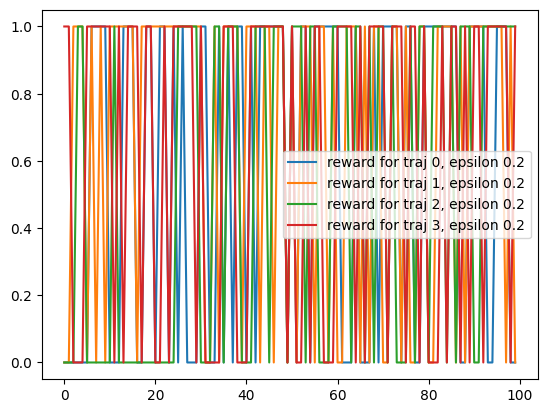

In [10]:
for i, reward in enumerate(rewards):
    plt.plot(range(len(reward)), reward,
            label=f"reward for traj {i}, epsilon {agent.epsilon}")
    plt.legend()
plt.show()

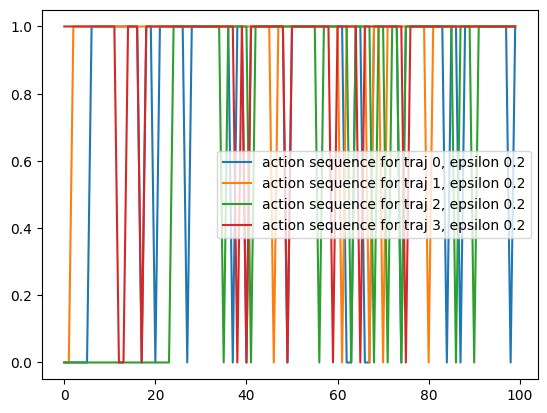

In [11]:
for i, action in enumerate(chosen_arms):
    plt.plot(range(len(action)), action,
            label=f"action sequence for traj {i}, epsilon {agent.epsilon}")
    plt.legend()
plt.show()

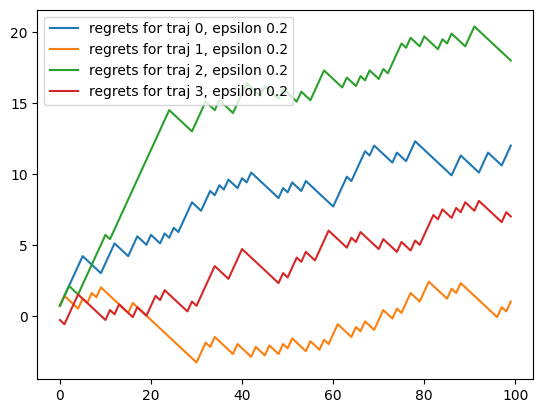

In [12]:
for i, action in enumerate(regrets):
    plt.plot(range(len(action)), action,
            label=f"regrets for traj {i}, epsilon {agent.epsilon}")
    plt.legend()
plt.show()

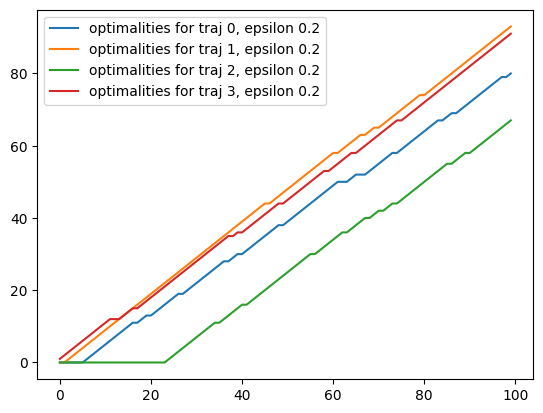

In [13]:
for i, action in enumerate(optimalities):
    plt.plot(range(len(action)), action,
            label=f"optimalities for traj {i}, epsilon {agent.epsilon}")
    plt.legend()
plt.show()

To try out different configurations, we create a function using the previous classes and pieces of code that we can easily call with parameter configuration. 

In [14]:
def train_epsilongreedy(agent, env, num_games, printed):

    chosen_arms = np.zeros(shape=(num_games, env.max_steps))
    rewards = np.zeros(shape=(num_games, env.max_steps))
    regrets = np.zeros(shape=(num_games, env.max_steps))
    optimalities = np.zeros(shape=(num_games, env.max_steps))

    for game in range(num_games):
        # playing the algo for `num_games` rounds
        agent.reset()
        env.reset()
        done = False
        while (not done):
            # playing the game until it is done
            action = agent.select_arm()
            _new_state, reward, done, _info = env.step(action)
            rewards[game, (env.count-1)] = reward
            chosen_arms[game, (env.count-1)] = action
            regrets[game, (env.count-1)] = env.regret
            optimalities[game, (env.count-1)] = env.played_optimal
            # update all the time 
            # IMPORTANT: different to explore then commit
            agent.update(action, reward)

    if printed:
        plt.subplot(4, 1, 1)
        for i, reward in enumerate(rewards):
            plt.plot(range(len(reward)), reward,
                     label=f"reward {i}, epsilon {agent.epsilon}")
            plt.legend()

        plt.subplot(4, 1, 2)
        for i, action in enumerate(chosen_arms):
            plt.plot(range(len(action)), action,
                     label=f"action sequence {i}, epsilon {agent.epsilon}")
            plt.legend()

        plt.subplot(4, 1, 3)
        for i, action in enumerate(regrets):
            plt.plot(range(len(action)), action,
                     label=f"regrets {i}, epsilon {agent.epsilon}")
            plt.legend()

        plt.subplot(4, 1, 4)
        for i, action in enumerate(optimalities):
            plt.plot(range(len(action)), action,
                     label=f"optimalities {i}, epsilon {agent.epsilon}")
            plt.legend()

        plt.show()

    return rewards, chosen_arms, regrets, optimalities

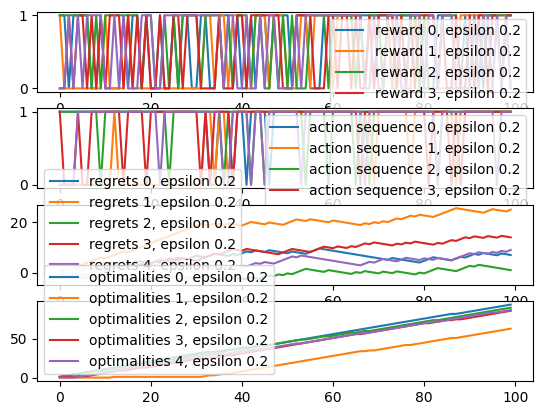

In [15]:
AGENT_EPSILON = 0.2
N_ARMS = 2
# probability parameter of bernoulli bandit problem
MEAN_PARAMETER = [0.1, 0.7]
MAX_STEPS = 100  # maximal gamestep
NUM_GAMES = 5  # games played of the greedy algorithm

agent = EpsilonGreedy(epsilon=AGENT_EPSILON, n_arms=N_ARMS)
gauss_multi_arm = BernoulliBanditEnv(
    p_parameter=MEAN_PARAMETER, max_steps=MAX_STEPS)

rewards, chosen_arms, regrets, optimalities = train_epsilongreedy(agent=agent, env=gauss_multi_arm, num_games=NUM_GAMES, printed=True)



Finally, we want to try our algorithm on the testbed described in Sutton's book. The idea here is to sample the parameter configuration of the arms and then test the algorithm on this. 

In [16]:
MAX_STEPS = 2000
N_ARMS = 10
USED_EPSILONS = [0.1, 0.2, 0.5]
NUM_GAMES = 3000


def epsilon_greedy_exp(max_steps, n_arms, used_epsilons, num_games, printed):

    statistics_mean = {}
    statistics_cumsum = {}
    statistics_regrets = {}
    statistics_optimalities = {}

    for epsilon in used_epsilons:
        agent = EpsilonGreedy(epsilon=epsilon, n_arms=n_arms)
        rewards = np.zeros(shape=(num_games, max_steps))
        regrets = np.zeros(shape=(num_games, max_steps))
        optimalities = np.zeros(shape=(num_games, max_steps))
        for game in range(num_games):
            mean_parameter = np.random.uniform(
                low=0.0, high=1.0, size=n_arms).tolist()
            env = BernoulliBanditEnv(
                p_parameter=mean_parameter, max_steps=max_steps)
            agent.reset()
            reward, _chosen_arms, regret, optimality = train_epsilongreedy(
                agent=agent, env=env, num_games=1, printed=False)
            rewards[game,] = reward
            regrets[game,] = regret
            optimalities[game,] = optimality

        mean_rewards = np.mean(rewards, axis=0)
        mean_cum_rewards = np.cumsum(mean_rewards)
        mean_regrets = np.mean(regrets, axis=0)
        mean_optimalities = np.mean(optimalities, axis=0)
        index_array = np.arange(len(mean_optimalities))
        mean_optimalities = mean_optimalities / (index_array + 1)

        statistics_mean[str(epsilon)] = mean_rewards
        statistics_cumsum[str(epsilon)] = mean_cum_rewards
        statistics_regrets[str(epsilon)] = mean_regrets
        statistics_optimalities[str(epsilon)] = mean_optimalities

        # print statistics in console
        print(50*"*")
        print(
            f"total mean reward with epsilon= {epsilon} is {mean_cum_rewards[-1]}")
        print(
            f"total regret with epsilon= {epsilon} is {mean_regrets[-1]}")
        print(
            f"total optimality with epsilon= {epsilon} is {mean_optimalities[-1]}")
        print(50*"*")

    if printed:
        plt.subplot(4, 1, 1)
        for used_epsi, traj in statistics_mean.items():
            plt.plot(range(len(traj)), traj,
                     label=f"mean reward, epsilon {used_epsi}")
            plt.legend()
        plt.subplot(4, 1, 2)
        for used_epsi, traj in statistics_cumsum.items():
            plt.plot(range(len(traj)), traj,
                     label=f"cumsum reward, ep {used_epsi}")
            plt.legend()
        plt.subplot(4, 1, 3)
        for used_epsi, traj in statistics_regrets.items():
            plt.plot(range(len(traj)), traj,
                     label=f"regrets, ep {used_epsi}")
            plt.legend()
        plt.subplot(4, 1, 4)
        for used_epsi, traj in statistics_optimalities.items():
            plt.plot(range(len(traj)), traj,
                     label=f"optimalities, ep {used_epsi}")
            plt.legend()
        plt.show()

    return statistics_mean, statistics_cumsum, statistics_regrets, statistics_optimalities



**************************************************
total mean reward with epsilon= 0.1 is 1698.054
total regret with epsilon= 0.1 is 118.61824162267789
total optimality with epsilon= 0.1 is 0.7091271666666666
**************************************************
**************************************************
total mean reward with epsilon= 0.2 is 1628.3663333333322
total regret with epsilon= 0.2 is 184.64190755570723
total optimality with epsilon= 0.2 is 0.6768514999999999
**************************************************
**************************************************
total mean reward with epsilon= 0.5 is 1397.4629999999981
total regret with epsilon= 0.5 is 418.1861513317151
total optimality with epsilon= 0.5 is 0.47346550000000004
**************************************************


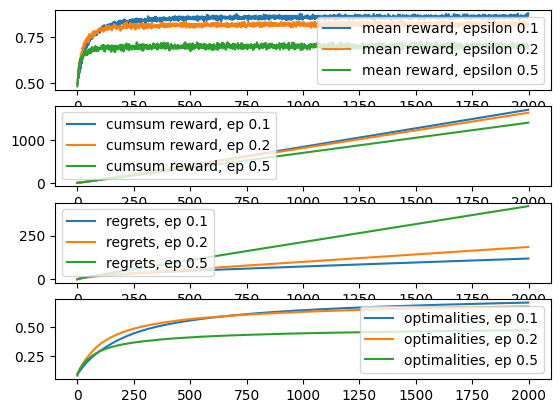

In [17]:
statistics_mean, statistics_cumsum, statistics_regrets, statistics_optimalities = epsilon_greedy_exp(max_steps=MAX_STEPS, n_arms=N_ARMS,
                          used_epsilons=USED_EPSILONS, num_games=NUM_GAMES, printed=True)
